In [2]:
train = pd.read_csv('train.csv',parse_dates=['first_active_month'])

### Basic  Exploration

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


In [4]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
feature_1,201917.0,3.105311,1.186160,1.000000,2.00000,3.000000,4.000000,5.000000
feature_2,201917.0,1.745410,0.751362,1.000000,1.00000,2.000000,2.000000,3.000000
feature_3,201917.0,0.565569,0.495683,0.000000,0.00000,1.000000,1.000000,1.000000
target,201917.0,-0.393636,3.850500,-33.219281,-0.88311,-0.023437,0.765453,17.965068


In [6]:
train.shape

(201917, 6)

In [5]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


### Target Column Exploration

Text(0,0.5,'Loyalty Score')

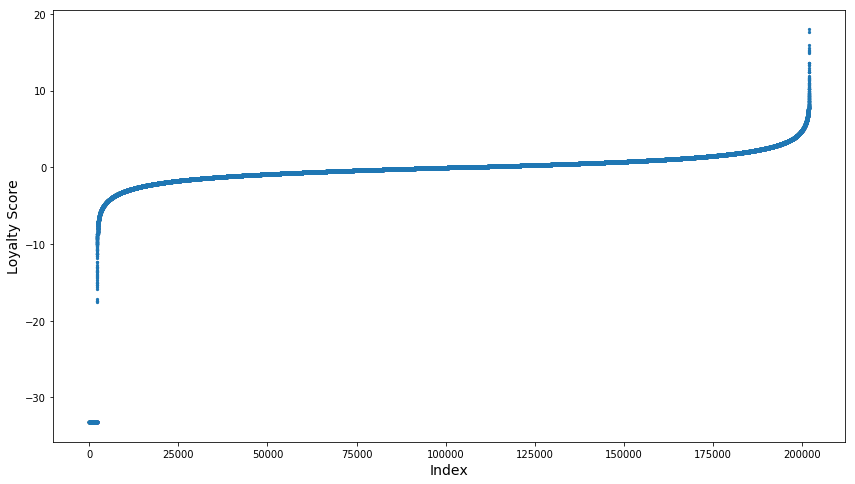

In [8]:
fig = plt.figure(figsize=(11,6))
ax = fig.add_axes([0,0,1,1])
ax.scatter(range(train.shape[0]),train['target'].sort_values(),s=5)
ax.set_xlabel('Index',fontsize=14)
ax.set_ylabel('Loyalty Score',fontsize=14)


Text(0,0.5,'Count')

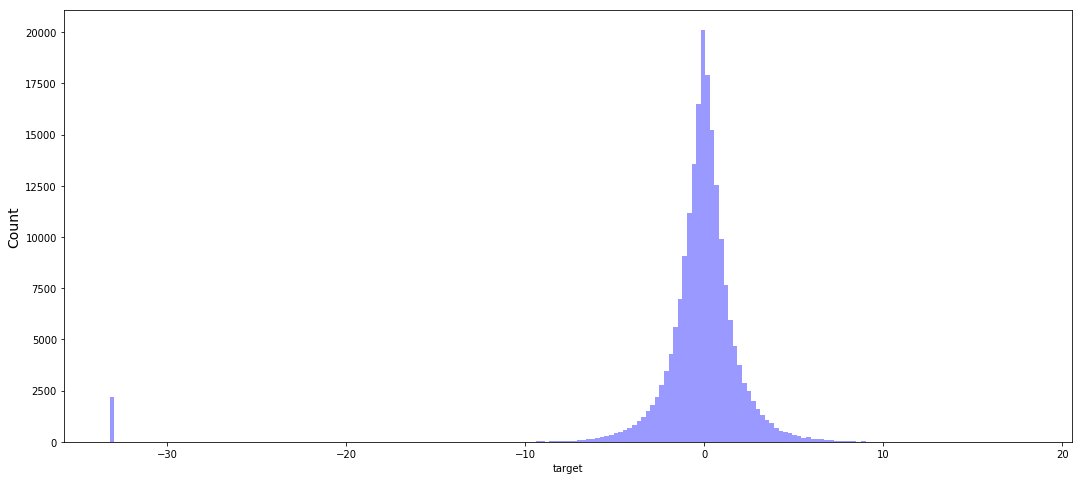

In [9]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_axes([0,0,1,1])
sns.distplot(train['target'], bins=200,kde=False,color='blue')
ax.set_ylabel('Count',fontsize=14)

奇怪的事情发生了！ Target 出现了小于负30的异常值，还贼鸡儿多！

In [10]:
(train['target'] <-30).sum() 

2207

In [11]:
2207/train.shape[0]

0.010930233709890698

In [31]:
train['target'][(train['target']>= -5) & (train['target'] <=5)] .count()

196106

In [32]:
196106/train.shape[0]

0.9712208481702878

In [46]:
(2207*((33-10)**2)/train.shape[0])**0.5  ## 计算异常值对RMSE可能的影响

2.4045984347770375

异常值占比1.09% , 比例较高并且偏离严重，会对RMSE产生较大影响, 以后可以想办法治治它们。

Leader Broad上的平均分在3.7左右 绝大部分Error是异常值造成的 

启发 ： 预测分为两部分 1.对普通值的预测 2. 对outliers的预测

### First_active_month Column Exploration


In [7]:
first_active_month = train['first_active_month'].value_counts().sort_index()
first_active_month.head(30)

2011-11-01      8
2011-12-01      2
2012-02-01      7
2012-03-01     10
2012-04-01     18
2012-05-01     28
2012-06-01     19
2012-07-01     29
2012-08-01     36
2012-09-01     38
2012-10-01     31
2012-11-01     48
2012-12-01     18
2013-01-01     23
2013-02-01     37
2013-03-01     58
2013-04-01     58
2013-05-01     94
2013-06-01     79
2013-07-01    110
2013-08-01    126
2013-09-01    121
2013-10-01    126
2013-11-01    132
2013-12-01    165
2014-01-01    144
2014-02-01    198
2014-03-01    242
2014-04-01    352
2014-05-01    431
Name: first_active_month, dtype: int64

Text(0,0.5,'Count')

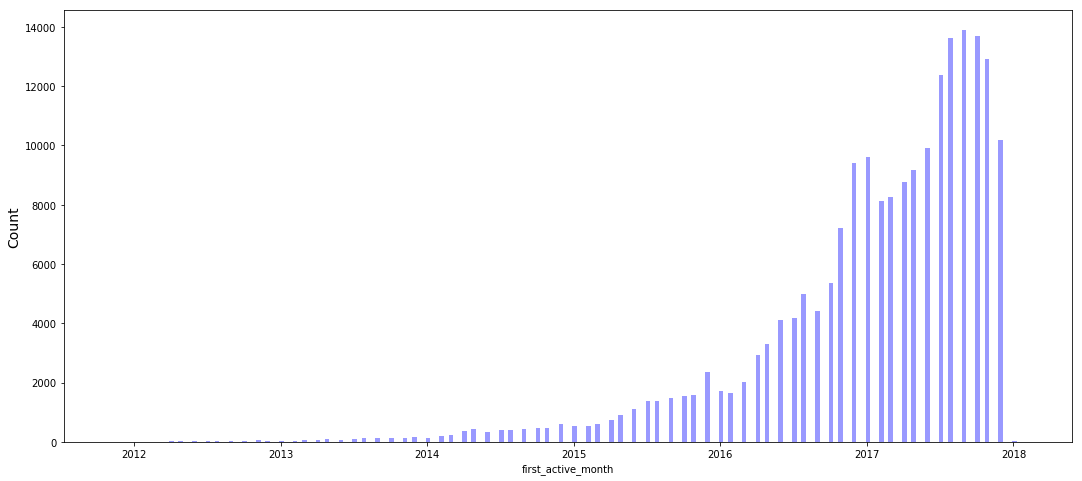

In [78]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_axes([0,0,1,1])
sns.distplot(train['first_active_month'], bins=200,kde=False,color='blue')
ax.set_ylabel('Count',fontsize=14)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74]), <a list of 75 Text xticklabel objects>)

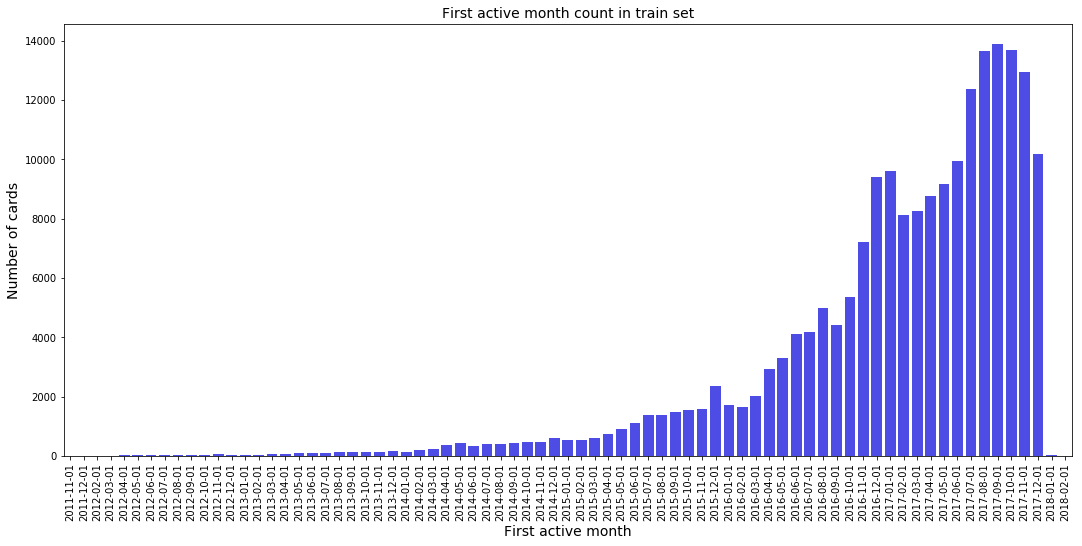

In [77]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_axes([0,0,1,1])
sns.barplot(first_active_month.index.astype('str'), first_active_month, alpha=0.8, color='blue')
ax.set_xlabel('First active month', fontsize=14)
ax.set_ylabel('Number of cards', fontsize=14)
ax.set_title("First active month count in train set", fontsize=14)
plt.xticks(rotation='vertical')


信用卡月激活数量总体上呈现上升趋势。
 
激活时间与target的变动是否有关？(理论上应该没有)

是否可以用时间组合出其他与target有关的特征？比如卡已使用时长？（这个可以有！）
 
激活数量的增长率似乎有周期性？

### Exploration of Feature 1, Feature 2 and Feature 3

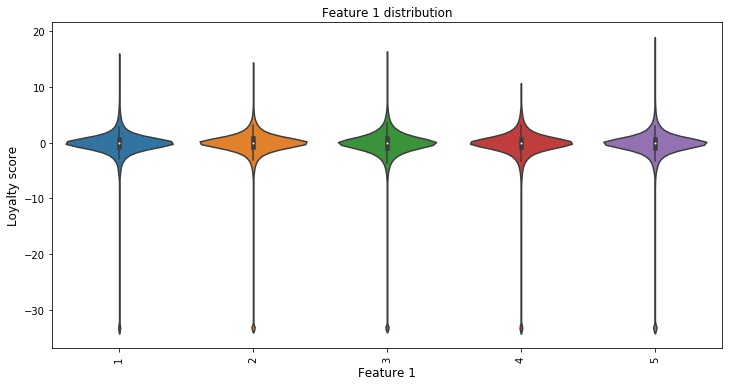

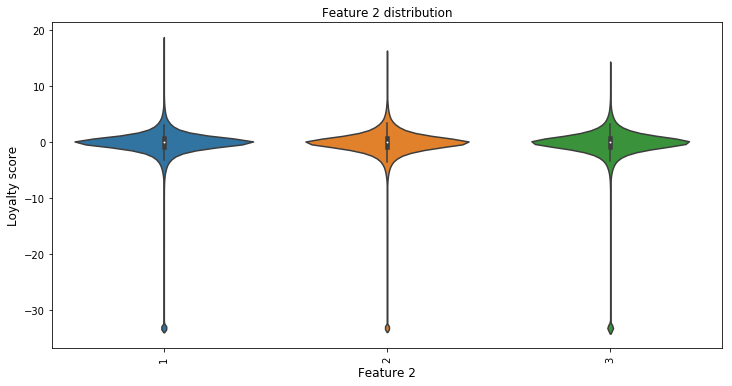

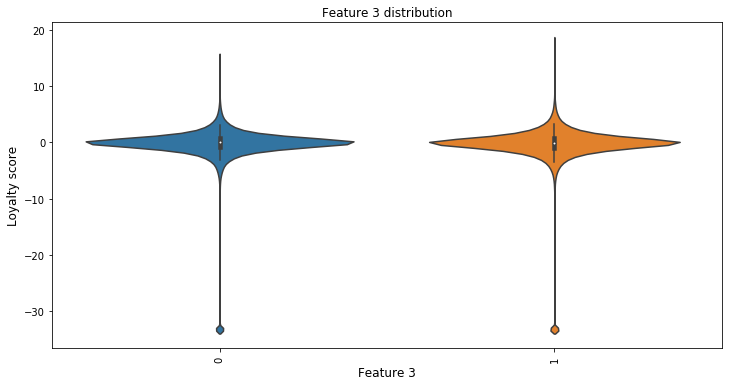

In [83]:
# feature 1
plt.figure(figsize=(12,6))
sns.violinplot(x="feature_1", y='target', data=train)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()

# feature 2
plt.figure(figsize=(12,6))
sns.violinplot(x="feature_2", y='target', data=train)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
plt.show()

# feature 3
plt.figure(figsize=(12,6))
sns.violinplot(x="feature_3", y='target', data=train)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
plt.show()

肉眼观察不出Feature_1 Feature_2 Feature_3 会对target的分布造成任何影响